## Backup
What I want in multithreaded processing:
- async operation of circular buffer.
- actor system.
    - actors can send message concurrently in a thread pool.
    - the message will be queued in FIFO (first-in-first-out) and sequentially processed in each actor.
    - the state will be accessed and modified sequentially.
    - the message queue can be set to be processed with priority.
        - or the message queue can be requeued if the message queue applies FIFO and the current message has to be processed later.
- task parallelism in processing function pipelines inside actors.
    - actor system deals with task (message) dispatch
    - high-performance processing pipeline (by task-oriented programming) executes tasks efficiently.

Before implementing directly on cell search, we first look at a series of simple examples that illustrates the possiblities of realizing the above functionalities.

### Async operation of circular buffer
The circular buffer has read and write functions. After data are read from buffer, they will be processed by a subsequent function named process_data. <br>
To show how async operation works:
- the time for processing data is relatively long (5s). 
- the time for reading data is short (1s).
- the time for writing data is slightly longer than reading (2s)

It should be observed that data are keeping written into the buffer while data are processed in the function.
- note, writing and reading are asynchronous, while reading and processing are sync.

In [4]:
import asyncio
import random
import time

class CircularBuffer:
    def __init__(self, size):
        self.buffer = [None] * size
        self.size = size
        self.write_index = 0
        self.read_index = 0

    def write(self, data):
        """Write data into the circular buffer."""
        self.buffer[self.write_index] = data
        print(f"Written '{data}' at index {self.write_index}")
        self.write_index = (self.write_index + 1) % self.size

    def read(self):
        """Read data from the circular buffer."""
        if self.buffer[self.read_index] is None:
            print(f"No new data at index {self.read_index}.")
            return None
        data = self.buffer[self.read_index]
        print(f"Read '{data}' from index {self.read_index}")
        self.buffer[self.read_index] = None  # Simulate consuming the data
        self.read_index = (self.read_index + 1) % self.size
        return data

def process_data(data):
    """Synchronous function to process the data."""
    print(f"Processing data: {data}")
    # Simulate a long-running synchronous operation
    time.sleep(5)
    print(f"Finished processing data: {data}")

async def write_to_buffer(buffer, interval):
    """Regularly write data into the circular buffer."""
    while True:
        data = random.randint(1, 100)  # Simulate some data to write
        buffer.write(data)
        await asyncio.sleep(interval)  # Simulate periodic writing

async def read_and_process(buffer, interval):
    """Asynchronously read from the circular buffer and process data in a separate thread."""
    loop = asyncio.get_running_loop()  # Get the event loop
    while True:
        data = buffer.read()
        if data is not None:
            # Use run_in_executor to run the process function in a separate thread
            await loop.run_in_executor(None, process_data, data)
        else:
            print("No data to read. Retrying...")
        await asyncio.sleep(interval)  # Simulate asynchronous, delayed reading

async def main():
    buffer_size = 5
    buffer = CircularBuffer(buffer_size)
    
    # Set the interval for reading and writing
    writer_interval = 2  # seconds
    reader_interval = 1  # seconds
    
    # Task to write to the buffer every 2 seconds
    writer_task = asyncio.create_task(write_to_buffer(buffer, writer_interval))
    
    # Task to read from the buffer every 1 second and process synchronously in a separate thread
    reader_task = asyncio.create_task(read_and_process(buffer, reader_interval))
    
    # Run both tasks concurrently, but stop after 50 seconds
    await asyncio.sleep(10)  # Let the tasks run for 50 seconds
    
    # Cancel the tasks after the time limit
    writer_task.cancel()
    reader_task.cancel()
    
    # Wait until the tasks are actually cancelled
    await asyncio.gather(writer_task, reader_task, return_exceptions=True)
    print("Tasks cancelled and program terminated after 10 seconds.")

# Run the program
await main()


Written '31' at index 0
Read '31' from index 0
Processing data: 31
Written '89' at index 1
Written '2' at index 2
Finished processing data: 31
Written '33' at index 3
Read '89' from index 1
Processing data: 89
Written '63' at index 4
Tasks cancelled and program terminated after 10 seconds.


Finished processing data: 89


### Actor system F1: 
Actors send messages concurrently in a thread pool. <br>
Three actors send greetings to each other. <br>
We should see the message that is sent later can be earlier printed in the results. 

In [247]:
import queue
import threading
import time
from concurrent.futures import ThreadPoolExecutor

class Actor:
    def __init__(self, name, actor_system):
        self.name = name
        self.message_queue = queue.Queue()
        self.actor_system = actor_system  # To send messages to other actors
    
    def send_message(self, message, reply_to=None):
        """Send a message to this actor, with an optional reply-to actor"""
        self.message_queue.put((message, reply_to))

    def process_messages(self):
        """Process messages sequentially from the message queue"""
        while True:
            message, reply_to = self.message_queue.get()
            if message == "STOP":
                break
            self.handle_message(message, reply_to)

    def handle_message(self, message, reply_to):
        """Handle the received message and send reply if necessary"""
        print(f"Actor {self.name} received message: {message}")
        time.sleep(2)  # Simulate some processing time

    def stop(self):
        """Stop the actor's message processing"""
        self.send_message("STOP", None)


class ActorSystem:
    def __init__(self, num_workers=3):  # Increased number of workers
        self.executor = ThreadPoolExecutor(max_workers=num_workers)
        self.actors = {}
    
    def create_actor(self, name):
        """Create an actor and run it"""
        actor = Actor(name, self)
        self.actors[name] = actor
        self.run_actor(actor)
        return actor
    
    def run_actor(self, actor):
        """Run an actor in the thread pool"""
        self.executor.submit(actor.process_messages)
    
    def send_message(self, target_actor_name, message, reply_to=None):
        """Send a message to a specific actor"""
        target_actor = self.actors.get(target_actor_name)
        if target_actor:
            target_actor.send_message(message, reply_to)

    def stop(self):
        """Stop the thread pool and all actors"""
        self.executor.shutdown(wait=True)


# Example Usage
if __name__ == "__main__":
    # Create an actor system with 3 threads (one for each actor)
    actor_system = ActorSystem(num_workers=3)
    
    # Create actors A, B, and C
    actor_a = actor_system.create_actor("A")
    actor_b = actor_system.create_actor("B")
    actor_c = actor_system.create_actor("C")
    
    # Send messages between actors
    actor_system.send_message("A", "Hello! from B", "B") # destination, message, sender
    actor_system.send_message("B", "Hello! from A", "A")
    
    # Simulate more complex interactions where A sends a message to B, and B replies back to A
    actor_system.send_message("B", "How are you? from A", "A")
    actor_system.send_message("A", "Doing well! from B", "B")
    
    # Introduce Actor C to send a message to Actor A
    actor_system.send_message("A", "How is everything? from C", "C")
    
    # Actor A can also send a message to Actor C
    actor_system.send_message("C", "Good! from A", "A")

    # Wait a bit to process the messages
    time.sleep(6)

    # Stop the actors gracefully
    actor_a.stop()
    actor_b.stop()
    actor_c.stop()

    # Shutdown the actor system (thread pool)
    actor_system.stop()


Actor C received message: Good! from A
Actor B received message: Hello! from A
Actor A received message: Hello! from B
Actor B received message: How are you? from A
Actor A received message: Doing well! from B
Actor A received message: How is everything? from C


### Actor system F2:
Within each actor, the received messages will be queued and sequentially processed. <br>
Each of the three actors will receive two greetings from the other two actors. <br>
It should be observed that the reply of greetings for each actor should be all after the send.

In [44]:
import queue
import time
from concurrent.futures import ThreadPoolExecutor

class Actor:
    def __init__(self, name, actor_system):
        self.name = name
        self.message_queue = queue.Queue()
        self.actor_system = actor_system  # To send messages to other actors

    def send_message(self, message, reply_to=None):
        """Send a message to this actor, with an optional reply-to actor"""
        self.message_queue.put((message, reply_to))
        # Print current message queue contents in FIFO order
        print(f"Actor {self.name}'s message queue: {[msg[0] for msg in list(self.message_queue.queue)]}")

    def process_messages(self):
        """Process messages sequentially from the message queue"""
        while True:
            message, reply_to = self.message_queue.get()  # Get message and reply_to info
            if message == "STOP":
                break
            self.handle_message(message, reply_to)

    def handle_message(self, message, reply_to):
        """Handle the received message and reply if needed based on message content"""
        print(f"Actor {self.name} processing message: '{message}'")
        time.sleep(1)  # Simulate processing time

    def stop(self):
        """Stop the actor's message processing"""
        self.message_queue.put(("STOP", None))


class ActorSystem:
    def __init__(self, num_workers=3):  # Number of worker threads
        self.executor = ThreadPoolExecutor(max_workers=num_workers)
        self.actors = {}

    def create_actor(self, name):
        """Create an actor and run it"""
        actor = Actor(name, self)
        self.actors[name] = actor
        self.run_actor(actor)
        return actor

    def run_actor(self, actor):
        """Run an actor in the thread pool"""
        self.executor.submit(actor.process_messages)

    def send_message(self, target_actor_name, message, reply_to=None):
        """Send a message to a specific actor"""
        target_actor = self.actors.get(target_actor_name)
        if target_actor:
            target_actor.send_message(message, reply_to)

    def stop(self):
        """Stop the thread pool and all actors"""
        self.executor.shutdown(wait=True)


# Example Usage
if __name__ == "__main__":
    # Create an actor system with 3 threads (one for each actor)
    actor_system = ActorSystem(num_workers=3)

    # Create actors A, B, and C
    actor_a = actor_system.create_actor("A")
    actor_b = actor_system.create_actor("B")
    actor_c = actor_system.create_actor("C")

    # Actor A asks
    actor_system.send_message("B", "How are you? from A", "A") 
    actor_system.send_message("C", "How are you? from A", "A") 
    
    # Actor B asks 
    actor_system.send_message("A", "Nice to meet you! from B", "B")
    actor_system.send_message("C", "Nice to meet you! from B", "B")

    # Actor C asks 
    actor_system.send_message("A", "How is everything? from C", "C")
    actor_system.send_message("B", "How is everything? from C", "C")

    # Wait a bit to process the messages
    time.sleep(5)

    # Stop the actors gracefully
    actor_a.stop()
    actor_b.stop()
    actor_c.stop()

    # Shutdown the actor system (thread pool)
    actor_system.stop()


Actor B's message queue: ['How are you? from A']
Actor C's message queue: ['How are you? from A']
Actor A's message queue: ['Nice to meet you! from B']
Actor C's message queue: ['How are you? from A', 'Nice to meet you! from B']
Actor A's message queue: ['Nice to meet you! from B', 'How is everything? from C']
Actor B's message queue: ['How are you? from A', 'How is everything? from C']
Actor B processing message: 'How are you? from A'
Actor C processing message: 'How are you? from A'Actor A processing message: 'Nice to meet you! from B'

Actor B processing message: 'How is everything? from C'
Actor C processing message: 'Nice to meet you! from B'
Actor A processing message: 'How is everything? from C'


### Actor system F3:
The state will be accessed and modified sequentially in actors. <br>
The actor B and actor C simultaneously sends one number (10 and 15) to the actor A, respectively. In the actor A, the two numbers will be both added to the inner state. <br>
It should be observed the state in the actor A should be 10 first then 25.

In [35]:
import queue
import time
from concurrent.futures import ThreadPoolExecutor

class Actor:
    def __init__(self, name, actor_system):
        self.name = name
        self.message_queue = queue.Queue()
        self.actor_system = actor_system  # To send messages to other actors
        self.state = 0  # Shared state, initialized to 0

    def send_message(self, message, reply_to=None):
        """Send a message to this actor, with an optional reply-to actor"""
        print(f"Message '{message}' enqueued for Actor {self.name}")
        self.message_queue.put((message, reply_to))

    def process_messages(self):
        """Process messages sequentially from the message queue"""
        while True:
            message, reply_to = self.message_queue.get()  # Get message and reply_to info
            if message == "STOP":
                print(f"Actor {self.name} is stopping.")
                break
            self.handle_message(message, reply_to)

    def handle_message(self, message, reply_to):
        """Handle the received message and update shared state"""
        print(f"Actor {self.name} received message: '{message}'")
        time.sleep(1)  # Simulate processing time

        print(f"Actor {self.name} is processing a numeric message: {message}")
        self.state += message
        print(f"Actor {self.name} state updated: {self.state}")

    def stop(self):
        """Stop the actor's message processing"""
        self.message_queue.put(("STOP", None))


class ActorSystem:
    def __init__(self, num_workers=3):  # Number of worker threads
        self.executor = ThreadPoolExecutor(max_workers=num_workers)
        self.actors = {}

    def create_actor(self, name):
        """Create an actor and run it"""
        actor = Actor(name, self)
        self.actors[name] = actor
        self.run_actor(actor)
        return actor

    def run_actor(self, actor):
        """Run an actor in the thread pool"""
        self.executor.submit(actor.process_messages)

    def send_message(self, target_actor_name, message, reply_to=None):
        """Send a message to a specific actor"""
        target_actor = self.actors.get(target_actor_name)
        if target_actor:
            print(f"ActorSystem sending message '{message}' from Actor {reply_to} to Actor {target_actor_name}")
            target_actor.send_message(message, reply_to)

    def stop(self):
        """Stop the thread pool and all actors, ensuring all messages are processed"""
        for actor in self.actors.values():
            actor.stop()
        self.executor.shutdown(wait=True)  # Wait for all threads to finish


# Example Usage
if __name__ == "__main__":
    # Create an actor system with 3 threads (one for each actor)
    actor_system = ActorSystem(num_workers=3)

    # Create actors A, B, and C
    actor_a = actor_system.create_actor("A")
    actor_b = actor_system.create_actor("B")
    actor_c = actor_system.create_actor("C")

    # Actor B sends messages with numbers to Actor A
    actor_system.send_message("A", 10, "B")  # Add 10 to the shared state of Actor A from Actor B

    # Actor C sends a message with a number to Actor A
    actor_system.send_message("A", 15, "C")  # Add 15 to the shared state of Actor A from Actor C

    # Wait a bit to process the messages
    time.sleep(5)  # Adjust as needed to ensure all messages are processed

    # Ensure actors are stopped after all messages are processed
    actor_system.stop() 

    # Shutdown the actor system (thread pool)
    print("Actor system stopped.")


ActorSystem sending message '10' from Actor B to Actor A
Message '10' enqueued for Actor A
ActorSystem sending message '15' from Actor C to Actor A
Message '15' enqueued for Actor A
Actor A received message: '10'
Actor A is processing a numeric message: 10
Actor A state updated: 10
Actor A received message: '15'
Actor A is processing a numeric message: 15
Actor A state updated: 25
Actor B is stopping.Actor A is stopping.Actor C is stopping.


Actor system stopped.


### Actor system F41:
The message quque can be set to be processed with priority. <br>
Continue with the last example, the actor A receives the number 10 first then 15. <br>
However, we want to observe the state is added to be first 15 then 25.

In [50]:
import queue
import time
from concurrent.futures import ThreadPoolExecutor

class Actor:
    def __init__(self, name, actor_system):
        self.name = name
        self.message_queue = queue.PriorityQueue()  # Priority Queue for messages
        self.actor_system = actor_system  # To send messages to other actors
        self.state = 0  # Shared state, initialized to 0

    def send_message(self, priority, message, reply_to=None):
        """Send a message with a priority to this actor, with an optional reply-to actor"""
        print(f"Message '{message}' with priority '{priority}' enqueued for Actor {self.name}")
        self.message_queue.put((priority, message, reply_to))  # Priority, message, and reply_to

    def process_messages(self):
        """Process messages sequentially from the message queue"""
        while True:
            priority, message, reply_to = self.message_queue.get()  # Get message, priority, and reply_to info
            if message == "STOP":
                print(f"Actor {self.name} is stopping.")
                break
            self.handle_message(priority, message, reply_to)

    def handle_message(self, priority, message, reply_to):
        """Handle the received message and update shared state"""
        print(f"Actor {self.name} received message: '{message}' with priority '{priority}'")
        time.sleep(1)  # Simulate processing time

        self.state += message
        print(f"Actor {self.name} state updated: {self.state}")

    def stop(self):
        """Stop the actor's message processing"""
        self.message_queue.put((0, "STOP", None))


class ActorSystem:
    def __init__(self, num_workers=3):  # Number of worker threads
        self.executor = ThreadPoolExecutor(max_workers=num_workers)
        self.actors = {}

    def create_actor(self, name):
        """Create an actor and run it"""
        actor = Actor(name, self)
        self.actors[name] = actor
        self.run_actor(actor)
        return actor

    def run_actor(self, actor):
        """Run an actor in the thread pool"""
        self.executor.submit(actor.process_messages)

    def send_message(self, target_actor_name, priority, message, reply_to=None):
        """Send a message with a priority to a specific actor"""
        target_actor = self.actors.get(target_actor_name)
        if target_actor:
            print(f"ActorSystem sending message '{message}' with priority '{priority}' from Actor {reply_to} to Actor {target_actor_name}")
            target_actor.send_message(priority, message, reply_to)

    def stop(self):
        """Stop the thread pool and all actors, ensuring all messages are processed"""
        for actor in self.actors.values():
            actor.stop()
        self.executor.shutdown(wait=True)  # Wait for all threads to finish


# Example Usage
if __name__ == "__main__":
    # Create an actor system with 3 threads (one for each actor)
    actor_system = ActorSystem(num_workers=3)

    # Create actors A, B, and C
    actor_a = actor_system.create_actor("A")
    actor_b = actor_system.create_actor("B")
    actor_c = actor_system.create_actor("C")

    # Actor B sends messages with different priorities to Actor A
    actor_system.send_message("A", 2, 10, "B")  # Lower priority for increment by 10
    actor_system.send_message("A", 1, 15, "C")  # Higher priority for increment by 15

    # Wait a bit to process the messages
    time.sleep(5)  # Adjust as needed to ensure all messages are processed

    # Stop actors A, B, and C after confirming all messages are processed
    actor_system.send_message("A", 0, "STOP")  # Stop Actor A last after all messages are processed
    time.sleep(2)  # Give enough time to process the stop message

    # Ensure actors are stopped after all messages are processed
    actor_system.stop()

    # Shutdown the actor system (thread pool)
    print("Actor system stopped.")


ActorSystem sending message '10' with priority '2' from Actor B to Actor A
Message '10' with priority '2' enqueued for Actor A
ActorSystem sending message '15' with priority '1' from Actor C to Actor A
Message '15' with priority '1' enqueued for Actor A
Actor A received message: '15' with priority '1'
Actor A state updated: 15
Actor A received message: '10' with priority '2'
Actor A state updated: 25
ActorSystem sending message 'STOP' with priority '0' from Actor None to Actor A
Message 'STOP' with priority '0' enqueued for Actor A
Actor A is stopping.
Actor B is stopping.
Actor C is stopping.
Actor system stopped.


### Actor system F42:
The messages in the message queue (in FIFO), which cannot be processed now, can be requeued to the end of the message queue for later processing. <br>
The below example works fundamentally similar to **controller** in cell search. <br>
The actor B and C send 0,1,2 three states to actor A. <br>
The initial state of actor A is 0. The rule of state transition is performed as follows:
- when state is 0, performs message of state 2. The inner state then switches to 2.
- when state is 2, performs message of state 1. The inner state then switches to 1.
- when state is 1, performs message of state 0. The inner state then switches to 0.

Otherwise, the message will be re-queued to the end of the message queue.

In [54]:
import queue
import time
from concurrent.futures import ThreadPoolExecutor

class Actor:
    def __init__(self, name, actor_system):
        self.name = name
        self.message_queue = queue.Queue()
        self.actor_system = actor_system  # To send messages to other actors
        self.state = 0  # Shared state, initialized to 0

    def send_message(self, message, reply_to=None):
        """Send a message to this actor, with an optional reply-to actor"""
        print(f"Message '{message}' enqueued for Actor {self.name}")
        self.message_queue.put((message, reply_to))

    def process_messages(self):
        """Process messages sequentially from the message queue"""
        while True:
            message, reply_to = self.message_queue.get()  # Get message and reply_to info
            if message == "STOP":
                print(f"Actor {self.name} is stopping.")
                break
            self.handle_message(message, reply_to)

    def handle_message(self, message, reply_to):
        """Handle the received message and update shared state based on specified rules"""
        print(f"Actor {self.name} received message: '{message}'")
        time.sleep(1)  # Simulate processing time

        # Only process messages based on the inner state
        if self.state == 0 and message == 2:
            print(f"Actor {self.name} processing message: {message}")
            self.state = 2
        elif self.state == 2 and message == 1:
            print(f"Actor {self.name} processing message: {message}")
            self.state = 1
        elif self.state == 1 and message == 0:
            print(f"Actor {self.name} processing message: {message}")
            self.state = 0
        else:
            # If the message isn't valid for the current state, requeue it
            print(f"Actor {self.name} requeuing message: {message} due to current state: {self.state}")
            self.message_queue.put((message, reply_to))  # Requeue the message

    def stop(self):
        """Stop the actor's message processing"""
        self.message_queue.put(("STOP", None))


class ActorSystem:
    def __init__(self, num_workers=3):  # Number of worker threads
        self.executor = ThreadPoolExecutor(max_workers=num_workers)
        self.actors = {}

    def create_actor(self, name):
        """Create an actor and run it"""
        actor = Actor(name, self)
        self.actors[name] = actor
        self.run_actor(actor)
        return actor

    def run_actor(self, actor):
        """Run an actor in the thread pool"""
        self.executor.submit(actor.process_messages)

    def send_message(self, target_actor_name, message, reply_to=None):
        """Send a message to a specific actor"""
        target_actor = self.actors.get(target_actor_name)
        if target_actor:
            print(f"ActorSystem sending message '{message}' from Actor {reply_to} to Actor {target_actor_name}")
            target_actor.send_message(message, reply_to)

    def stop(self):
        """Stop the thread pool and all actors, ensuring all messages are processed"""
        for actor in self.actors.values():
            actor.stop()
        self.executor.shutdown(wait=True)  # Wait for all threads to finish


# Example Usage
if __name__ == "__main__":
    # Create an actor system with 3 threads (one for each actor)
    actor_system = ActorSystem(num_workers=3)

    # Create actors A, B, and C
    actor_a = actor_system.create_actor("A")
    actor_b = actor_system.create_actor("B")
    actor_c = actor_system.create_actor("C")

    # Actors B and C send messages with numbers to Actor A
    actor_system.send_message("A", 0, "B")  # Process 2 when state is 0
    actor_system.send_message("A", 1, "C")  # Will be requeued
    actor_system.send_message("A", 2, "B")  # Will be requeued

    # Wait a bit to process the messages
    time.sleep(10)  # Adjust as needed to ensure all messages are processed

    # Ensure actors are stopped after all messages are processed
    actor_system.stop()

    # Shutdown the actor system (thread pool)
    print("Actor system stopped.")


ActorSystem sending message '0' from Actor B to Actor A
Message '0' enqueued for Actor A
ActorSystem sending message '1' from Actor C to Actor A
Message '1' enqueued for Actor A
ActorSystem sending message '2' from Actor B to Actor A
Message '2' enqueued for Actor A
Actor A received message: '0'
Actor A requeuing message: 0 due to current state: 0
Actor A received message: '1'
Actor A requeuing message: 1 due to current state: 0
Actor A received message: '2'
Actor A processing message: 2
Actor A received message: '0'
Actor A requeuing message: 0 due to current state: 2
Actor A received message: '1'
Actor A processing message: 1
Actor A received message: '0'
Actor A processing message: 0
Actor A is stopping.
Actor B is stopping.
Actor C is stopping.
Actor system stopped.


### Task parallelism inside actors
We want actor system to dispatch the right task to the right processing pipeline based on the system's state. <br>
Within each actor, we want the task can be executed effectively by task-oriented programming, e.g., TBB. <br>
In the below example, we compute a square (pure) function within an actor in a parallel way to show multithreaded computation can be performed inside an actor. After that, the vector of squared values will be accumulated to the inner state of the actor. <br>
It should be observed that on the top level, the actor processes the received message one at the time (with order) and for each message, multiple threads are simultaneously used to compute a square (pure) function. Furthermore, the state should be accumulated correctly.

In [55]:
import threading
from concurrent.futures import ThreadPoolExecutor
import time
import queue
import os

# Base Actor class for message-passing and sequential message processing
class Actor:
    def __init__(self):
        self.message_queue = queue.Queue()

    def send_message(self, message):
        self.message_queue.put(message)

    def stop(self):
        self.message_queue.put("STOP")

# WorkerActor uses TBB-like parallelism for task processing
class WorkerActor(Actor):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.executor = ThreadPoolExecutor(max_workers=4)  # Simulating TBB with ThreadPool
        self.state = 0  # Shared state, but only updated sequentially

    def process_task(self, data):
        # Simulate parallel processing and print thread ID to show concurrent execution
        def task(x):
            print(f"Processing {x} on thread {threading.get_ident()}")
            time.sleep(1)  # Simulate work delay
            return x * x

        results = list(self.executor.map(task, data))  # Parallel computation
        print(f"{self.name} processed data {data} -> {results}")

        # After parallel processing, update state sequentially
        self.update_state(sum(results))

    def update_state(self, result_sum):
        # Sequentially update shared state (no locks needed)
        self.state += result_sum
        print(f"{self.name} updated state to: {self.state}")

    def process_messages(self):
        """Actor's thread processes messages sequentially"""
        while True:
            message = self.message_queue.get()
            if message == "STOP":
                print(f"Worker {self.name} is stopping.")
                break
            self.process_task(message)  # Hand off task to TBB for parallel execution

# PriorActor that sends tasks to WorkerActor
class PriorActor(Actor):
    def __init__(self, worker_actor):
        super().__init__()
        self.worker_actor = worker_actor

    def send_task_to_worker(self, task):
        print(f"PriorActor is sending task: {task} to WorkerActor")
        self.worker_actor.send_message(task)

    def process_messages(self):
        """Process messages sent to PriorActor if needed (not used in this example)"""
        pass

# Example of how the system works
if __name__ == "__main__":
    # Create WorkerActor
    worker_actor = WorkerActor("WorkerActor")

    # Create PriorActor that sends tasks to WorkerActor
    prior_actor = PriorActor(worker_actor)

    # Start worker actor in a separate thread (actor's thread)
    threading.Thread(target=worker_actor.process_messages).start()

    # PriorActor sends tasks to WorkerActor
    prior_actor.send_task_to_worker([1, 2, 3, 4])
    prior_actor.send_task_to_worker([5, 6, 7, 8])

    # Allow time for processing
    time.sleep(5)

    # Stop the worker actor
    worker_actor.stop()


PriorActor is sending task: [1, 2, 3, 4] to WorkerActor
PriorActor is sending task: [5, 6, 7, 8] to WorkerActor
Processing 1 on thread 140229292787456
Processing 2 on thread 140228937381632
Processing 3 on thread 140228928988928
Processing 4 on thread 140228920596224
WorkerActor processed data [1, 2, 3, 4] -> [1, 4, 9, 16]
WorkerActor updated state to: 30
Processing 5 on thread 140229292787456
Processing 6 on thread 140228937381632
Processing 7 on thread 140228928988928
Processing 8 on thread 140228920596224
WorkerActor processed data [5, 6, 7, 8] -> [25, 36, 49, 64]
WorkerActor updated state to: 204
Worker WorkerActor is stopping.


## Next Tasks: Implement Cell Search
We first make sure that the cell search can work by applying actor system. <br>
Thus, we skip lower-level task-oriented programming for the time being. 
- The message passing is based on the smallest granularity, i.e., one OFDM symbol.
- If lower-level task-oriented programming is applied, we may need to complicate the tasks (messages).

The implementation of cell search in actor system is divided into the following steps:
1. build init synchronization actor and keep passing data (One OFDM symbol) to it. See the right detection of frame timing.
2. build channel estimation actor and keep passing data (four OFDM symbols of PBCH) to it. See the channel estimation with the order (time and frequency intepolation).
3. pass different data simultaneously to the two actors to see they will be operated asynchronously.
4. build circular buffer (with dispatcher) actor.
5. connect circular buffer and cell search, circular buffer and crs. Passing data from circular buffer to the actors in the same thread pool.
6. TBH

### Step 0: prepare data

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import asn1tools
import queue
from concurrent.futures import ThreadPoolExecutor, Future

In [29]:
# read metadata
meta_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-meta'

with open(meta_filename, 'r') as f:
    meta_data = json.load(f)

In [30]:
data_type = meta_data['global']['core:datatype']
Fs = meta_data['global']['core:sample_rate']

if data_type == 'cf32_le':
    dtype = np.complex64
elif data_type == 'ci16_le':
    dtype = np.int16
elif data_type == 'ci8_le':
    dtype = np.int8
else:
    raise ValueError(f"Unsupported data type: {data_type}")

In [31]:
# read data
data_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-data'

with open(data_filename, 'rb') as f:
    tmp = np.fromfile(f,dtype=dtype)  # Adjust dtype as needed

In [32]:
scale = 2**(-15)
rx = scale*tmp[0::2] + scale*1j*tmp[1::2]

In [33]:
fc = 10e6
rx_unfr = rx*np.exp(-2j*np.pi*fc*np.arange(len(rx))/Fs)

h = signal.remez(60, [0, 4.5e6, 5.5e6, Fs/2], [1, 0], fs=Fs)
w, H = signal.freqz(h, fs=Fs)
rxf = np.convolve(rx_unfr,h)

In [34]:
rxf = rxf[::2]
Fs = Fs // 2

# system parameters
N_FFT = Fs // 15000
N_CP = 144 // 2 # normal CP
N_CP_extra = 16 // 2
half_frame = (Fs*5) // 1000 # 5 ms 

### Step 1: build cell search (init synchronization) actor.

In [35]:
# pss built functions
def seq_zadoff_chu(u):

    n = np.arange(63)
    d_u = np.exp(-1j*np.pi*u*n*(n+1)/63)
    d_u[31] = 0
    
    return d_u


def zadoff_chu(u,N_FFT):

    zc = seq_zadoff_chu(u)
    
    # mapping to resource elements
    re = np.zeros(N_FFT,complex)
    re[N_FFT//2-31:N_FFT//2+32] = zc
    
    return np.fft.ifft(np.fft.ifftshift(re)) 

In [36]:
# sss built functions
def tilde_s():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+2] ^ x[i] # xor operation
                
    return 1-2.0*x

def tilde_c():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+3] ^ x[i] # xor operation
        
    return 1-2.0*x

def tilde_z():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+4] ^ x[i+2] ^ x[i+1] ^ x[i] # xor operation
        
    return 1-2.0*x

def m_01(N_id_1):
    
    q_prime = N_id_1 // 30
    q = (N_id_1 + q_prime*(q_prime+1)/2) // 30
    m_prime = N_id_1 + q*(q+1)/2
    m_0 = int(m_prime % 31)
    m_1 = int((m_0+m_prime//31+1) % 31)
    
    return (m_0,m_1)

def m_sequence(N_id_1,N_id_2,F,N_FFT):
    
    # F: 0 or 1, denoting first half or second half
    
    m_0,m_1 = m_01(N_id_1)
    ts = tilde_s()
    tc = tilde_c()
    tz = tilde_z()
    # print(ts)
    
    c_0 = np.roll(tc,-N_id_2) # left cyclic shift operation 
    c_1 = np.roll(tc,-N_id_2-3) 
    
    s_0 = np.roll(ts,-m_0) 
    s_1 = np.roll(ts,-m_1) 
    
    z_10 = np.roll(tz,-(m_0%8))
    z_11 = np.roll(tz,-(m_1%8))
    
    d = np.zeros(62)
    if F == 0:
        
        d[0::2] = s_0 * c_0
        d[1::2] = s_1 * c_1 * z_10
    elif F == 1:
        
        d[0::2] = s_1 * c_0
        d[1::2] = s_0 * c_1 * z_11
                
    re = np.zeros(N_FFT)
    re[N_FFT//2-31:N_FFT//2] = d[:31]
    re[N_FFT//2+1:N_FFT//2+32] = d[31:]
    
    # return time domain SSS
    return np.fft.ifft(np.fft.ifftshift(re)) 

In [37]:
# compute pss and sss sequences and their norm
def pss_sss_norm(N_FFT):
    pss = []
    pss_norm = []
    sss = []
    sss_norm = [[]]*3
    u = [25,29,34]
    for n in range(3):
        pss_t = zadoff_chu(u[n],N_FFT)
        pss.append(pss_t)
        pss_norm.append(np.linalg.norm(pss_t))
        for m in range(168):
            for F in range(2):
                sss_t = m_sequence(m,n,F,N_FFT)
                sss.append(sss_t)
                # n: N_id_2, even: first half, odd: second half.
                sss_norm[n].append(np.linalg.norm(sss_t))

    return pss,sss,pss_norm,sss_norm

In [38]:
# cell search actor
class CellSearch(object):
    def __init__(self,N_FFT):
        self.message_queue = queue.Queue()
        self.shift_reg = [None] * 2
        self.prior_sym = []
        self.nsym = 0 # the number of incoming sym (msg)
        self.N_FFT = N_FFT
        self.pss,self.sss,self.pss_norm,self.sss_norm = pss_sss_norm(N_FFT)
        self.pss_start = None
        self.N_id_2 = None
        
    def send_message(self,message,future=None):
        # send a message to this actor
        # when a message is sent, a Future object is created and passed along with the message.
        # this Future object is used to capture the result of processing the message.
        self.message_queue.put((message, future))

    def process_message(self):
        # process messages sequentially from the message queue
        while True:
            message,future = self.message_queue.get() # data message: 'destination', 'data'
            self.nsym += 1
            self.prior_sym = self.shift_reg.pop(0) # prior
            self.shift_reg.append(message['sym']) # append new
            pss_nsym,pss_start,N_id_2 = self.match_pss()
            if pss_start != None: # pss is successfully decoded.
                print('pss located at sample index: {:d}, N_id_2: {:d}'.format((pss_nsym-1)*self.N_FFT+pss_start,N_id_2))
                self.reset_pss()
            # After processing the message, the actor sets the result in the Future object
            future.set_result((pss_nsym,pss_start,N_id_2))
     
    def match_pss(self,threshold=0.5):
        # concatenate two OFDM symbols in the shift reg
        # start time: shift register has no symbol inside it.
        if any(sym is None for sym in self.shift_reg):
            return (self.nsym-1,self.pss_start,self.N_id_2) # start
        else:
            sym_blocks = np.concatenate(self.shift_reg)
        # pss search
        search = True
        ind = self.N_FFT
        max_corr = 0
        while search and ind < len(sym_blocks):
            # extract sliding sym blocks.
            sym = sym_blocks[ind-self.N_FFT:ind]
            for n in range(3): # three u
                corr = np.abs(np.sum(sym*np.conj(self.pss[n])))/np.linalg.norm(sym)/self.pss_norm[n]
                if corr > threshold:
                    # we want to find the peak of correlation 
                    if corr > max_corr: 
                        max_corr = corr
                    else:
                        search = False
                        self.N_id_2 = n
                        self.pss_start = ind-self.N_FFT-1
            ind += 1 
        # return the symbol number of pss, where it starts at that symbol and N_id_2
        return (self.nsym-1,self.pss_start,self.N_id_2)
    
    def reset_pss(self):
        self.pss_start = None

In [39]:
# define an actor system
class ActorSystem(object):
    def __init__(self, num_workers=3):  # Increased number of workers
        self.executor = ThreadPoolExecutor(max_workers=num_workers)
    
    def create_actor(self, actor):
        """Create an actor and run it"""
        self.run_actor(actor)        

        return actor
    
    def run_actor(self, actor):
        """Run an actor in the thread pool"""
        self.executor.submit(actor.process_message)
    
    def send_message(self, target_actor, message):
        """Send a message to a specific actor"""
        future = Future()
        target_actor.send_message(message, future)
        return future

In [40]:
# keep sending messages to cell_search actor
actor_system = ActorSystem()

cell_search = actor_system.create_actor(CellSearch(N_FFT))

win = N_FFT
ob_len = half_frame*2 + N_FFT

while win < ob_len:
    
    data = rxf[win-N_FFT:win]
    message = {'destination':'CellSearch','sym':data}
    control_info = actor_system.send_message(cell_search,message)
    if control_info.result()[1] != None:
        cell_info = control_info.result()
    win += N_FFT
    
print(cell_info)

pss located at sample index: 132605, N_id_2: 0
(130, 509, 0)


### Step 2: build channel estimation actor

In [41]:
# fft 
def extract_OFDM(ofdm_symbol,N_rb,N_rb_sc=12):
    
    re = np.fft.fftshift(np.fft.fft(ofdm_symbol))
    
    # length of occupied subcarriers
    N_sc = N_rb*N_rb_sc
    N_FFT = len(ofdm_symbol)
        
    # since we want to read the information in REs, we need to skip DC
    active_sc = np.concatenate((np.arange(N_FFT//2-N_sc//2,N_FFT//2),np.arange(N_FFT//2+1,N_FFT//2+N_sc//2+1)))
    
    return re[active_sc]

# strip cp
def strip_cp(message,N_CP,N_CP_extra):
    if message['l'] == 0:
        return message['sym'][N_CP+N_CP_extra:]    
    else:
        return message['sym'][N_CP:]

In [42]:
# crs built functions
def c_sequence(M,c_init,Nc=1600):
    
    x_1 = np.zeros(M+Nc,dtype=np.uint8)
    x_1[0] = 1
    for n in range(31,M+Nc):
        x_1[n] = x_1[n-28] ^ x_1[n-31]
        
    x_2 = np.zeros(M+Nc,dtype=np.uint8)
    for n in range(31):
        x_2[n] = (c_init & (1<<n)) >> n 
    for n in range(31,M+Nc):
        x_2[n] = x_2[n-28] ^ x_2[n-29] ^ x_2[n-30] ^ x_2[n-31]
    
    return x_1[Nc:] ^ x_2[Nc:]    

def crs_sequence(ns,l,N_id,N_cp=1,N_rb_max=110):
    
    # ns: slot number.
    # l: OFDM symbol number
    
    c_init = 2**10*(7*(ns+1)+l+1)*(2*N_id+1)+2*N_id+N_cp
    c = c_sequence(4*N_rb_max,c_init)
    
    return np.sqrt(0.5)*((1-2.0*c[0::2]) + 1j*(1-2.0*c[1::2]))

def crs_in_re(p,l,ns,N_id,N_rb,N_rb_max=110):
    
    # p: antenna port number
    # l: OFDM symbol number
    # ns: slot number
    
    nu = -1
    if p == 0 and l == 0:
        nu = 0
    elif p == 0 and l == 4:
        nu = 3
    elif p == 1 and l == 0:
        nu = 3
    elif p == 1 and l == 4:
        nu = 0
    elif p == 2 and l == 1: 
        nu = 3*(ns%2) 
    elif p == 3 and l == 1:
        nu = 3 + 3*(ns%2) 
        
    if nu == -1:
        return (None,None)
        
    nu_shift = N_id % 6
    
    cs = crs_sequence(ns,l,N_id)
    
    m = np.arange(2*N_rb)
    m_prime = m + N_rb_max - N_rb
    crs = cs[m_prime] # value of crs
    
    k = 6*m + (nu + nu_shift) % 6 # index of crs
    
    return (k,crs) 

In [48]:
# channel estimate actor
class ChannelEstimate(object):
    def __init__(self,N_CP,N_CP_extra,Fs,N_dl_sc=12):
        self.message_queue = queue.Queue()     
        self.ns = 0
        self.N_id = None
        self.N_rb = None
        self.ant = None
        self.fd = None
        self.N_dl_sc = N_dl_sc
        self.N_CP = N_CP
        self.N_CP_extra = N_CP_extra
        self.Fs = Fs
        self.k = []
        self.crs = []
        self.h_sym = []
                
    def send_message(self,message,future=None):
        self.message_queue.put((message, future)) 
        
    def process_message(self):
        while True:
            message,future = self.message_queue.get() # data message: 'destination', 'data'
            self.update_sys(message)
            sym = strip_cp(message,self.N_CP,self.N_CP_extra)
            # correcting frequency offset
            sym = sym*np.exp(-2j*np.pi*self.fd*(np.arange(len(sym))+message['l']*len(sym))/self.Fs) 
            message['sym'] = extract_OFDM(sym,self.N_rb) # bw truncation
            # symbol estimation: we focus on 2 antenna
            if self.ant <= 2:
                if message['l'] in [0,4]:  
                    message = self.est_h(message) # the sym coming into channel estimation has been frequency symbol.
                else:
                    message = self.intepolate(message) 
            # channel estimate actor generates data info
            print(message['sym'][:5])
            future.set_result(message)  
    
    def update_sys(self,message):
        # update system info for crs with different BW and locations
        if self.N_rb != message['rb']:
            self.N_rb = message['rb']
            self.h_sym = np.zeros((message['ant'],message['rb']*self.N_dl_sc),complex)
        if self.N_id != message['N_id']:
            self.N_id = message['N_id']
        if self.ant != message['ant']:
            self.ant = message['ant']
        if self.fd != message['fd']:
            self.fd = message['fd']
        if message['l'] in [0,4]: # crs at sym0 and sym4
            self.ns = message['ns']
            self.k = [[]]*message['ant']
            self.crs = [[]]*message['ant']
            for p in range(message['ant']):
                # update position and value of crs at different locations
                self.k[p],self.crs[p] = crs_in_re(p,message['l'],message['ns'],self.N_id,message['rb'])
            
    def est_h(self,message): # based on one subframe.
        l = message['l']
        re_sym = message['sym']
        if l in [0,4]:
            self.h_sym[0][self.k[0]] = re_sym[self.k[0]] * np.conj(self.crs[0])
            if self.ant == 2:
                self.h_sym[1][self.k[1]] = re_sym[self.k[1]] * np.conj(self.crs[1]) 
        # intepolation in freq (within one ofdm symbol)
        for p in range(self.ant):
            for kk in range(self.N_rb*self.N_dl_sc):
                n = self.k[p][np.argmin(np.abs(self.k[p] - kk))]
                self.h_sym[p][kk] = self.h_sym[p][n]
        message['h'] = self.h_sym
        return message
                        
    def intepolate(self,message): # in time
        message['h'] = self.h_sym
        return message

In [44]:
channel_estimate = actor_system.create_actor(ChannelEstimate(N_CP,N_CP_extra,Fs))

N_id = 324
pss_start = 286205
pbch_start = pss_start + N_FFT # start of slot 1
N_rb = 6
ns = 1
f_d = 1379.3996018718585
ant = 2
sym = []
h = [[] for _ in range(ant)]

for l in range(4):
    if l == 0:
        CP = N_CP + N_CP_extra
    else:
        CP = N_CP
        
    message = {'destination':'MIBDecoding','sym':rxf[pbch_start:pbch_start+N_FFT+CP],'ns':ns,'l':l,'rb':N_rb,'fd':f_d,'h':[],'ant':ant,'N_id':N_id}
    data_info = actor_system.send_message(channel_estimate,message)
    pbch_start += N_FFT + CP
    sym.append(data_info.result()['sym'])
    for p in range(ant):
        h[p].append(data_info.result()['h'][p])

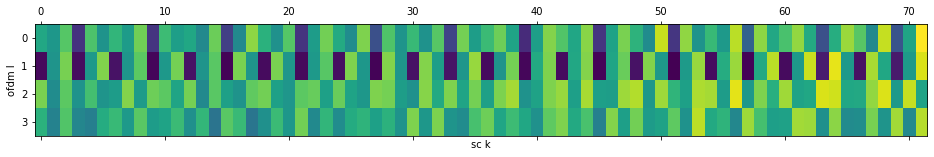

In [47]:
plt.matshow(np.abs(sym),aspect='auto')
plt.xlabel('sc k')
plt.ylabel('ofdm l')
plt.show()

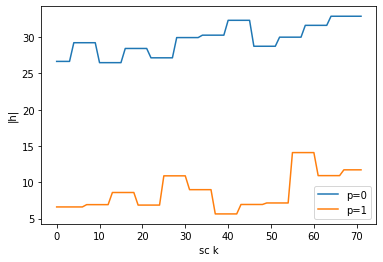

In [46]:
for p in range(2):        
    plt.plot(np.abs(h[p][0]),label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend()
plt.show()

### Step 3: merge two actors in one thread pool
Concurrent computation occurs if later results from early loop.

In [50]:
actor_system = ActorSystem()

cell_search = actor_system.create_actor(CellSearch(N_FFT))
channel_estimate = actor_system.create_actor(ChannelEstimate(N_CP,N_CP_extra,Fs))

win = N_FFT
ob_len = half_frame*2 + N_FFT

while win < ob_len:
    
    data = rxf[win-N_FFT:win]
    message = {'destination':'CellSearch','sym':data}
    control_info = actor_system.send_message(cell_search,message)
    win += N_FFT
    
N_id = 324
pss_start = 286205
pbch_start = pss_start + N_FFT # start of slot 1
N_rb = 6
ns = 1
f_d = 1379.3996018718585
ant = 2

for l in range(4):
    if l == 0:
        CP = N_CP + N_CP_extra
    else:
        CP = N_CP
    
    sym = rxf[pbch_start:pbch_start+N_FFT+CP]
    message = {'destination':'MIBDecoding','sym':sym,'ns':ns,'l':l,'rb':N_rb,'fd':f_d,'h':[],'ant':ant,'N_id':N_id}
    data_info = actor_system.send_message(channel_estimate,message)
    pbch_start += N_FFT + CP

[13.31926218+23.09926257j 22.85365289 -5.77381622j
 20.98044302+25.18648574j  6.57772099 +0.67267893j
 22.39732496-22.87465474j]


[  0.66547079 +0.98661463j -16.28442764+16.20350449j
 -32.70019925+13.13975828j   1.54388144 +0.44956439j
 -22.95384234 +7.33526028j]
[-32.2469777 +14.67425331j  14.75861928-15.75620918j
 -23.84418829+23.17733126j   9.4775846 +20.80387165j
 -21.12105788+22.81457215j]
[ 18.45719894-21.47757105j  -6.34583358-18.79995955j
  29.48639088-13.52398473j -12.22720983+16.3838473j
 -17.33863596 +8.25563605j]
pss located at sample index: 132605, N_id_2: 0


### Step 5: build circular buffer (with dispatcher) actor
We should note:
- circular buffer is a function (or, a class) inside dispatcher, which is the real actor. 
- the position (state) of reading and writing pointer resides in the dispatcher actor.
- data is written inside the circular buffer; the read and process, i.e., send data info based on message (control info) from message queue of dispatcher, is performed asynchronously.

In [1]:
# circular buffer function (class)
# note: read and write pointer, who catch who. Neither of them can pass each other.
class CircularBuffer(object):
    def __init__(self,buffer_size):
        self.read_pointer = 0
        self.write_pointer = 0
        self.pass_origin = False
        # pass origin false: read behind write, read cannot pass write.
        # pass origin true: write behind read, write cannot pass read.
        self.buffer_size = buffer_size
        self.buffer = [None] * buffer_size
        
    def read_data(self,length):
        read_tmp = self.read_pointer + length
        if length > self.buffer_size:
            print('warning')
        else:   
            if not self.pass_origin:
                if read_tmp <= self.write_pointer:
                    return self.buffer[self.read_pointer:read_tmp]
                else:
                    print('warning')
            else:
                if read_tmp <= self.buffer_size:
                    return self.buffer[self.read_pointer:read_tmp]
                elif read_tmp % self.buffer_size <= self.read_pointer
                

                 
        assert length <= self.size
        # read data from read pointer cannot over write pointer.
        # but let dispatch to justify the data can be read or not.
        if self.read_pointer + length <= self.buffer_size:
            return self.buffer[self.read_pointer:self.read_pointer+length]
        else:
            return np.concatenate((self.buffer[self.read_pointer:self.buffer_size],self.buffer[:(self.read_pointer+length)%self.buffer_size]))
        
    def write_data(self,data):
        write_tmp = self.write_pointer + len(data)
        if not self.pass_origin: # read behind write
            if write_tmp < self.buffer_size: # not pass origin
                self.buffer[self.write_pointer:write_tmp] = data
                self.write_pointer = write_tmp
            elif write_tmp % self.buffer_size <= self.read_pointer: # pass the origin but not pass read pointer
                self.pass_origin = True
                self.buffer[self.write_pointer:self.buffer_size] = data[:self.buffer_size-self.write_pointer]
                self.buf[:write_tmp % self.buffer_size] = data[self.buffer_size-self.write_pointer:]
                self.write_pointer = write_tmp % self.buffer_size
            else:
                print('warning') # the case of data won't be written to the circular buffer should be justified in dispatcher. 
        elif write_tmp <= self.read_pointer: # write not catch read
            self.buf[self.write_pointer:write_tmp] = data
            self.write_pointer = write_tmp
        else: 
            print('warning') # the case of data won't be written to the circular buffer should be justified in dispatcher. 

    def reset_read(self):
        self.read_pointer = 0
        
    def reset_write(self):
        self.write_pointer = 0               

In [ ]:
# checking the accuracy of circular buffer
cb = CircularBuffer(N_FFT)

# write 600

# read 700, warning


In [ ]:
# dispatcher actor
class Dispatcher(object):
    def __init__(self):
        self.message_queue = queue.Queue()
        
        
    def send_message():
        pass
    
    def process_message():
        # reply
        pass

In [ ]:
# circular buffer keeps writing data into it.
# dispatcher receives the control info from controller and reply data info to pss.